/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


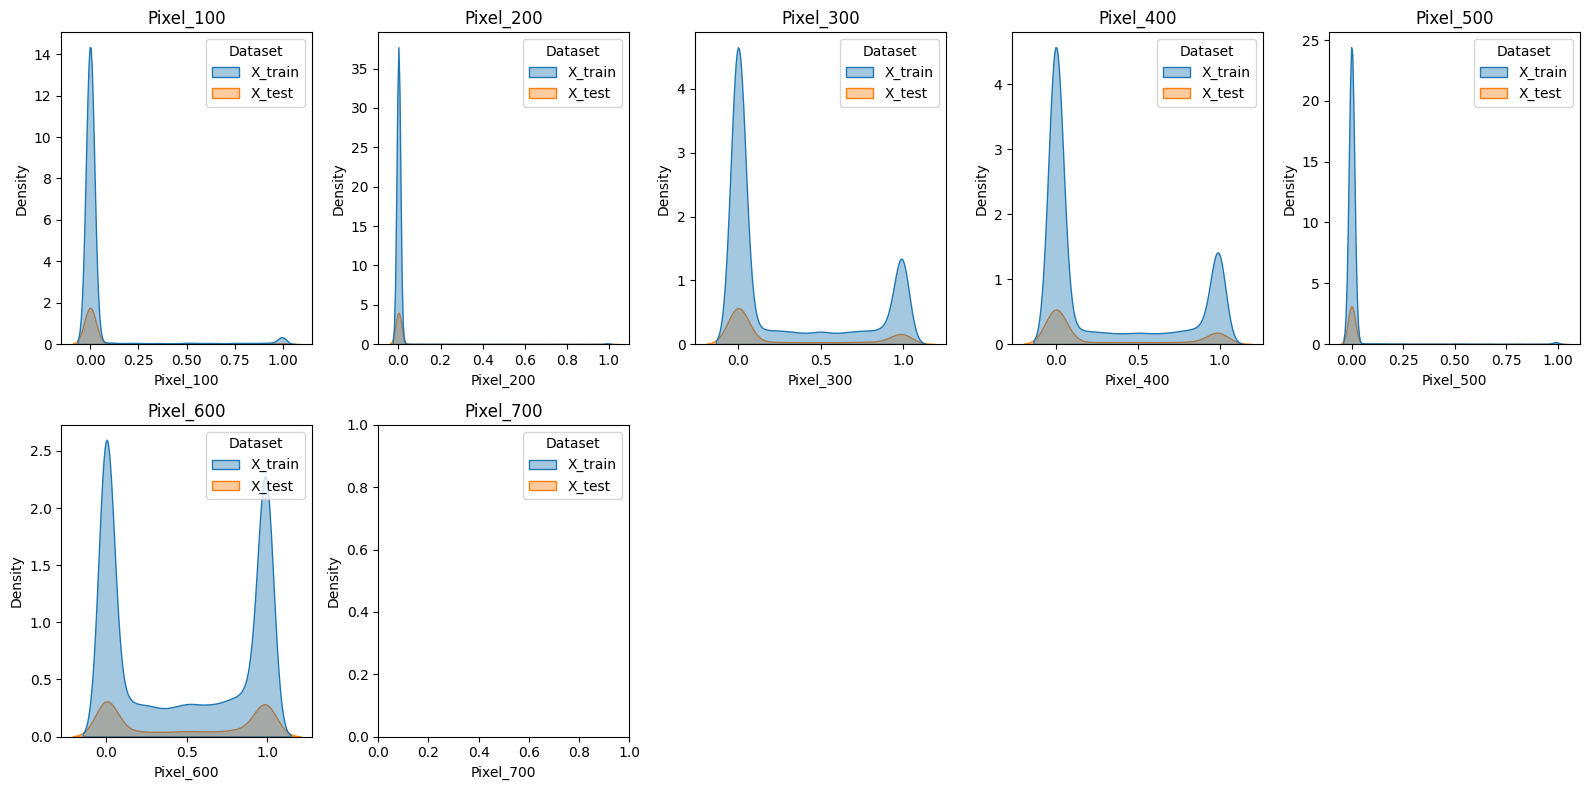

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import os

# Seed setter
def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEEDS = [27, 272, 2727, 1, 30]

# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()

# Normalize images to [0,1]
X_train_raw = X_train_raw.astype('float32') / 255.
X_test_raw = X_test_raw.astype('float32') / 255.

# Visualize distributions of a few pixels (as features)
feature_indices = [100, 200, 300, 400, 500, 600, 700]
# Flatten for feature extraction
X_train_flat = X_train_raw.reshape((X_train_raw.shape[0], -1))
X_test_flat = X_test_raw.reshape((X_test_raw.shape[0], -1))

df1 = pd.DataFrame(X_train_flat[:, feature_indices], columns=[f'Pixel_{i}' for i in feature_indices])
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

df2 = pd.DataFrame(X_test_flat[:, feature_indices], columns=[f'Pixel_{i}' for i in feature_indices])
df2['Label'] = y_test
df2['Dataset'] = 'X_test'

df_all = pd.concat([df1, df2], ignore_index=True)

plt.figure(figsize=(16, 8))
for i, feature in enumerate(df1.columns[:-2]):
    plt.subplot(2, 5, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', fill=True, alpha=0.4)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Noise function (Gaussian noise)
def add_noise(X, noise_type='gaussian', gaussian_scale=0.1):
    if noise_type == 'gaussian':
        noise = np.random.normal(0, gaussian_scale, X.shape)
        X_noisy = X + noise
        X_noisy = np.clip(X_noisy, 0., 1.)
        return X_noisy, noise
    else:
        raise NotImplementedError

# Add noise to flattened training images for classical ML models
X_train_noisy_flat, dX_flat = add_noise(X_train_flat, gaussian_scale=0.2)

# For CNN, keep images 28x28x1 with noise added on raw images
X_train_noisy_img, dX_img = add_noise(X_train_raw[..., np.newaxis], gaussian_scale=0.2)
X_test_img = X_test_raw[..., np.newaxis]

# ==== Import your custom libs ====
# import PRF, PRF4DF, deepforest (assumed installed and compatible)
import PRF
import PRF4DF
from deepforest import CascadeForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

n_classes = len(np.unique(y_train))
n_features = X_train_noisy_flat.shape[1]



In [2]:

n_cascade_estimators = 4


# === PDRF ===
accuracies_PDRF = []

for seed in SEEDS:
    set_all_seeds(seed)
    model = CascadeForestClassifier(
        n_bins=n_classes,
        random_state=seed,
    )
    prf_estimators = []
    for i in range(n_cascade_estimators):
        estimator = PRF4DF.SklearnCompatiblePRF(
            n_classes_=n_classes,
            n_features_=n_features,
            use_probabilistic_labels=False,
            use_feature_uncertainties=True,
            n_estimators=10,
            max_depth=10,
            random_state=i,
            n_jobs=1
        )
        prf_estimators.append(estimator)
    model.set_estimator(prf_estimators)

    # concatenate noisy + noise features as input
    X_train_combined = np.hstack((X_train_noisy_flat, dX_flat))
    model.fit(X_train_combined, y_train)

    # test set + zeros for noise
    X_test_combined = np.hstack((X_test_flat, np.zeros_like(X_test_flat)))
    acc = model.score(X_test_combined, y_test)
    accuracies_PDRF.append(acc)

print(f"PDRF Accuracy: {np.mean(accuracies_PDRF):.4f} ± {np.std(accuracies_PDRF):.4f}")


[2025-06-07 16:35:01.256] Start to fit the model:
[2025-06-07 16:35:01.257] Fitting cascade layer = 0 


: 

In [5]:

# === PRF ===
accuracies_PRF = []

for seed in SEEDS:
    set_all_seeds(seed)
    prf_cls = PRF.prf(n_estimators=10, bootstrap=True)
    prf_cls.fit(X_train_noisy_flat, y_train, dX_flat)
    score = prf_cls.score(X_test_flat, y_test)
    accuracies_PRF.append(score)

print(f"PRF Accuracy: {np.mean(accuracies_PRF):.4f} ± {np.std(accuracies_PRF):.4f}")

# === Random Forest ===
accuracies_RF = []

for seed in SEEDS:
    set_all_seeds(seed)
    rf = RandomForestClassifier(n_estimators=50, random_state=seed)
    rf.fit(X_train_noisy_flat, y_train)
    y_pred = rf.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    accuracies_RF.append(acc)

print(f"Random Forest Accuracy: {np.mean(accuracies_RF):.4f} ± {np.std(accuracies_RF):.4f}")

# === Deep Forest ===
accuracies_DF = []

for seed in SEEDS:
    set_all_seeds(seed)
    clf = CascadeForestClassifier(n_estimators=2, random_state=seed)
    clf.fit(X_train_noisy_flat, y_train)
    y_pred = clf.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    accuracies_DF.append(acc)

print(f"Deep Forest Accuracy: {np.mean(accuracies_DF):.4f} ± {np.std(accuracies_DF):.4f}")


: 

In [ ]:

# === CNN ===
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

accuracies_CNN = []

for seed in SEEDS:
    print(f"Training CNN with seed {seed}...")
    set_all_seeds(seed)
    model = create_cnn_model()
    model.fit(X_train_noisy_img, y_train_cat, epochs=10, batch_size=128, verbose=0)
    y_pred_prob = model.predict(X_test_img)
    y_pred = np.argmax(y_pred_prob, axis=1)
    acc = accuracy_score(y_test, y_pred)
    accuracies_CNN.append(acc)
    print(f"Seed {seed} CNN accuracy: {acc:.4f}")

print(f"CNN Accuracy: {np.mean(accuracies_CNN):.4f} ± {np.std(accuracies_CNN):.4f}")


In [ ]:

# === Kernel SVM ===
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

set_all_seeds(SEEDS[0])
model_svm = SVC()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(model_svm, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_noisy_flat, y_train)
best_svm = grid.best_estimator_

accuracies_KSVM = []
for seed in SEEDS:
    set_all_seeds(seed)
    y_pred = best_svm.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    accuracies_KSVM.append(acc)

print(f"Kernel SVM Accuracy: {np.mean(accuracies_KSVM):.4f} ± {np.std(accuracies_KSVM):.4f}")


In [ ]:

# === Plot and Save ===

comparison_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "CNN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_CNN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_CNN),
        np.std(accuracies_KSVM),
    ]
})

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Mean Accuracy', data=comparison_df, yerr=comparison_df['Std'])
plt.ylim(0.7, 1.0)
plt.title('Model Comparison on MNIST with Noise')
plt.show()

comparison_df.to_csv('results_mnist.csv', index=False)
